In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.utils.class_weight
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, BaggingRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
import pandas as pd
from imblearn.over_sampling import SMOTE 


Prepare the dataset


In [208]:
dataset=pd.read_csv("train_set.tsv",sep='\t',header=0)

#print(dataset["num_collisions"].value_counts(normalize=False))

X=dataset.iloc[:,:-2]  # : all raws :-2 slice out the last 2 columns
y=dataset.iloc[:,-2]   #just the last column

#normalized_df=(dataset-dataset.mean())/dataset.std()
normalized_df=(X-X.min())/(X.max()-X.min())  #between 0 and 1 (is column-wise)
#print(normalized_df.describe)
random_state=12
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=random_state) #to be reproducible
print(y_train.value_counts(normalize=False))

X_train,y_train=SMOTE(k_neighbors=1).fit_resample(X_train,y_train)
print(y_train.value_counts(normalize=False))

print("Number of training samples: %d" %(X_train.shape[0]))
print("Number of test samples: %d" %(X_test.shape[0]))


0    381
1    226
2     68
3     23
4      2
Name: num_collisions, dtype: int64
1    381
2    381
0    381
3    381
4    381
Name: num_collisions, dtype: int64
Number of training samples: 1905
Number of test samples: 300


GaussianNB

Input shape reduced train: (1905, 2)
Input shape reduced test: (300, 2)


Text(0.5, 1.0, 'Training and test samples')

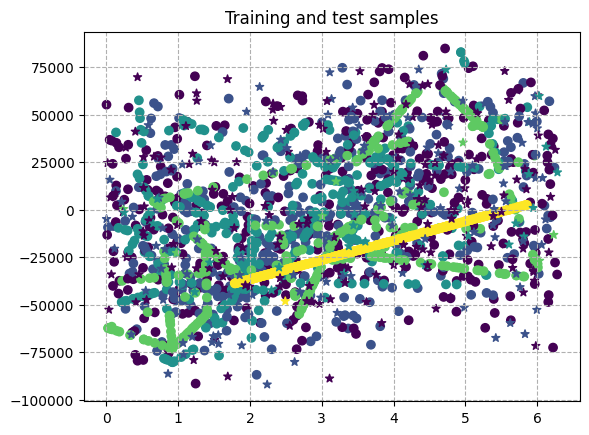

In [209]:
# select the first two features
X_train_reduced = X_train.iloc[:,0:2]
X_test_reduced = X_test.iloc[:,0:2]
print("Input shape reduced train: %s" %str(X_train_reduced.shape))
print("Input shape reduced test: %s" %str(X_test_reduced.shape))

plt.figure()
plt.scatter(X_train_reduced.iloc[:,0], X_train_reduced.iloc[:,1], c=y_train)
plt.scatter(X_test_reduced.iloc[:,0], X_test_reduced.iloc[:,1], c=y_test, marker="*")
plt.grid(linestyle="--")
plt.title("Training and test samples")

In [210]:
print(np.unique(y_train))
p=np.divide(y.value_counts().to_numpy(),y.shape[0])
print(p)
gen_model = GaussianNB(priors=p)
gen_model.fit(X_train_reduced, y_train)



[0 1 2 3 4]
[0.538 0.333 0.096 0.03  0.003]


GaussianNB(priors=array([0.538, 0.333, 0.096, 0.03 , 0.003]))

In [211]:
y_pred = gen_model.predict(X_test_reduced)
acc = accuracy_score(y_pred, y_test)    
print("Accuracy %.3f" %acc)
#0.553 with 0:2
#0.573 with 1:2
#0.580 with 2:4
#grid search to find best features


Accuracy 0.523


Ensemble of Gaussian,Perception,Least Square,SVM with BOOSTING (trying to improve Aaccuracy)


In [212]:
class LeastSquare:

    def __init__(self):
        self.w = [0, 0, 0]

    def fit(self,X,t):
        n = len(X) 
        t2 = np.c_[t, 1-t] 
        phi = np.c_[np.ones(n), X] 
        self.w = np.matmul(np.linalg.pinv(phi),t2) 
        print("Least square solution: %s" %(str(self.w.transpose())))

    def predict(self,x):
        xn = np.array((1, x[0][0], x[0][1]))
        yn = np.matmul(self.w.transpose(),xn) #W.T*x
        if yn[0]>yn[1]:
            return 1
        else:
            return -1

In [233]:
classifier_name = 'G'
algorithm = 'SAMME' 
n_estimators=np.random.randint(5, 70, 5)

all_classifiers = {
    'G': [GaussianNB, 'Gaussian Naive Bayes'],
    'P': [Perceptron, 'Perceptron'],   
    'D': [DecisionTreeClassifier(criterion="entropy"), 'Decision Tree'],
    'S': [svm.SVC(C=1.0,kernel='poly', degree=3, gamma='scale'), 'SVM']     
    }

#print(sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0,1,2,3,4]), y=y))

boosting_params = {
  'learning_rate': np.random.uniform(size=5),
  'n_estimators': n_estimators,
  }

In [234]:

adaboost_classifier = AdaBoostClassifier(
    base_estimator=all_classifiers[classifier_name][0](), 
    n_estimators=30, 
    learning_rate=0.9, 
    algorithm= algorithm, 
    random_state=random_state
    ).fit(X_train, y_train)

y_pred=adaboost_classifier.predict(X_test)
ada_accuracy_train = adaboost_classifier.score(X_train, y_train)  
ada_accuracy_test = adaboost_classifier.score(X_test,y_test)
print("Accuracy on train_set: %.3f" %ada_accuracy_train,"Accuracy on test_set: %.3f" %ada_accuracy_test)
print(sklearn.metrics.f1_score(y_test, y_pred,average=None))

Accuracy on train_set: 0.655 Accuracy on test_set: 0.387
[0.51162791 0.33846154 0.13333333 0.07142857 0.        ]


In [235]:
cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
grid_search_boosting = GridSearchCV(
    adaboost_classifier,
    boosting_params, 
    scoring='accuracy', 
    cv=cv, 
    return_train_score=False,
    verbose=0
)
grid_search_boosting.fit(X_train, y_train)
#Best parameters for the classifier
print("Best classification hyper-parameters for boosting classifier: %r" %grid_search_boosting.best_params_)
print("Best accuracy: %.4f" %grid_search_boosting.best_score_)
print("Boosting Accuracy over the test set: %.4f" %grid_search_boosting.score(X_test, y_test))

Best classification hyper-parameters for boosting classifier: {'learning_rate': 0.8520285669986938, 'n_estimators': 66}
Best accuracy: 0.6730
Boosting Accuracy over the test set: 0.4333
